In [276]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate, Multiply, Reshape, ActivityRegularization
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

from carl.learning.calibration import HistogramCalibrator, IsotonicCalibrator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from awkde import GaussianKDE

In [250]:
# Data
data_dir = '../data'

X_train = np.load(data_dir + '/unweighted_events/X_train_point_by_point_9.npy')
y_train = np.load(data_dir + '/unweighted_events/y_train_point_by_point_9.npy')
r_train = np.load(data_dir + '/unweighted_events/r_train_point_by_point_9.npy')

X_calibration = np.load(data_dir + '/unweighted_events/X_calibration.npy')
weights_calibration = np.load(
    data_dir + '/unweighted_events/weights_calibration.npy')

X_test = np.load(data_dir + '/unweighted_events/X_test.npy')
r_test = np.load(data_dir + '/unweighted_events/r_test.npy')[9]
    
# Scale data
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype=np.float64))
X_train_transformed = scaler.transform(X_train)
X_calibration_transformed = scaler.transform(X_calibration)
X_test_transformed = scaler.transform(X_test)

log_r_gradients_train = np.zeros((r_train.shape[0], 43))
log_r_gradients_train[:,0] = np.log(r_train)

In [4]:
theta1 = 708
theta = 9

# Covariance matrix in X space

In [15]:
X_indices = [0,1,2,3,39,40,41] # j1 momentum + delta eta, delta phi, mjj

X_small = X_train_transformed[::,X_indices]
print(X_small.shape)

cov_X = np.cov(X_small, rowvar=False)
print(cov_X)

print(np.linalg.eigvals(cov_X))

(100000, 7)
[[ 1.00000999e+00  3.04642194e-01 -4.20358716e-03 -1.45445187e-03
   6.94878939e-01  4.37157687e-01 -2.59416426e-02]
 [ 3.04642194e-01  1.00000996e+00  3.24991309e-03 -8.91122202e-03
   2.51928216e-01 -2.13436816e-01  1.02183965e-01]
 [-4.20358716e-03  3.24991309e-03  1.00001000e+00 -3.39882936e-03
  -1.32251408e-02 -6.38066174e-03  3.17357045e-03]
 [-1.45445187e-03 -8.91122202e-03 -3.39882936e-03  1.00001000e+00
  -3.70690703e-04  3.82102752e-03 -3.53395291e-03]
 [ 6.94878939e-01  2.51928216e-01 -1.32251408e-02 -3.70690703e-04
   1.00001001e+00  6.99713729e-01 -3.41566077e-02]
 [ 4.37157687e-01 -2.13436816e-01 -6.38066174e-03  3.82102752e-03
   6.99713729e-01  1.00000999e+00 -1.45000465e-01]
 [-2.59416426e-02  1.02183965e-01  3.17357045e-03 -3.53395291e-03
  -3.41566077e-02 -1.45000465e-01  1.00001001e+00]]
[2.27228293 0.15581463 0.38228855 1.27829369 0.91191818 0.9965207
 1.00295129]


# Regressor

In [17]:
n_features = 42

def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x

    return f

def hidden_layers(n,
                  hidden_layer_size=100,
                  activation='tanh',
                  dropout_prob=0.0):
    r = []
    for k in range(n):
        if dropout_prob > 0.:
            s = stack_layer([
                Dropout(dropout_prob),
                Dense(hidden_layer_size, activation=activation)
            ])
        else:
            s = stack_layer([Dense(hidden_layer_size, activation=activation)])
        r.append(s)
    return stack_layer(r)

def loss_function_regression(y_true, y_pred):
    return losses.mean_squared_error(y_true[:,0], y_pred[:,0])

def make_regressor(n_hidden_layers=3,
                   hidden_layer_size=100,
                   activation='tanh',
                   dropout_prob=0.0):

    # Inputs
    input_layer = Input(shape=(n_features,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
    log_r_hat_layer = Dense(1, activation='linear')(hidden_layer)
    s_hat_layer = Lambda(lambda x : 1. / 1. + x)(log_r_hat_layer)

    # gradients with respect to x
    gradient_layer = Lambda(lambda x: K.gradients(x[0], x[1])[0],
                            output_shape=(n_features,))([s_hat_layer, input_layer])

    # Combine outputs
    output_layer = Concatenate()([log_r_hat_layer, gradient_layer])
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile model
    model.compile(loss=loss_function_regression,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [18]:
# Train score regression
regr = KerasRegressor(lambda: make_regressor(n_hidden_layers=2),
                     epochs=20, verbose=2, validation_split=0.2,
                     callbacks=[EarlyStopping(verbose=1, patience=3)])

regr.fit(X_train_transformed, log_r_gradients_train)

Train on 80000 samples, validate on 20000 samples
Epoch 1/20
 - 4s - loss: 0.1503 - val_loss: 0.1830
Epoch 2/20
 - 3s - loss: 0.0687 - val_loss: 0.1257
Epoch 3/20
 - 3s - loss: 0.0485 - val_loss: 0.0869
Epoch 4/20
 - 3s - loss: 0.0355 - val_loss: 0.0919
Epoch 5/20
 - 3s - loss: 0.0289 - val_loss: 0.0693
Epoch 6/20
 - 3s - loss: 0.0244 - val_loss: 0.0606
Epoch 7/20
 - 3s - loss: 0.0226 - val_loss: 0.0676
Epoch 8/20
 - 4s - loss: 0.0202 - val_loss: 0.0533
Epoch 9/20
 - 3s - loss: 0.0189 - val_loss: 0.0578
Epoch 10/20
 - 4s - loss: 0.0178 - val_loss: 0.0453
Epoch 11/20
 - 4s - loss: 0.0170 - val_loss: 0.0520
Epoch 12/20
 - 5s - loss: 0.0159 - val_loss: 0.0386
Epoch 13/20
 - 4s - loss: 0.0147 - val_loss: 0.0417
Epoch 14/20
 - 5s - loss: 0.0143 - val_loss: 0.0565
Epoch 15/20
 - 4s - loss: 0.0133 - val_loss: 0.0372
Epoch 16/20
 - 4s - loss: 0.0130 - val_loss: 0.0383
Epoch 17/20
 - 4s - loss: 0.0118 - val_loss: 0.0471
Epoch 18/20
 - 5s - loss: 0.0120 - val_loss: 0.0475
Epoch 00018: early stop

In [19]:
calibration_predictions = regr.predict(X_calibration_transformed)
log_r_hat_calibration = calibration_predictions[:,0]
s_hat_calibration = 1. / (1. + np.exp(log_r_hat_calibration))
gradients_calibration = calibration_predictions[:,1:]

# Calculate bandwidths

In [187]:
grad_cov_grad = np.diag( gradients_calibration[:,X_indices].dot(cov_X.dot(gradients_calibration[:,X_indices].T)))
print(grad_cov_grad.shape, np.mean(grad_cov_grad), np.var(grad_cov_grad))

(19994,) 2.4857344420761236 135.53229477292066


In [235]:
mean_bw_nom = 1.5*1.5/11.4 * 1.5/2.37 * 1.5/1.8
mean_bw_den = 1.1*1.1/5.85 * 1.09/1.27 * 1.09 / 1.2

bandwidths = np.sqrt(grad_cov_grad)
bandwidths = np.clip(bandwidths, np.mean(bandwidths) / 100., np.mean(bandwidths) * 100.)
bandwidths_nom = mean_bw_nom / np.mean(bandwidths) * bandwidths
bandwidths_nom = np.clip(bandwidths_nom, 0.1,10.)
bandwidths_den = mean_bw_den / np.mean(bandwidths) * bandwidths
bandwidths_den = np.clip(bandwidths_den, 0.1,10.)

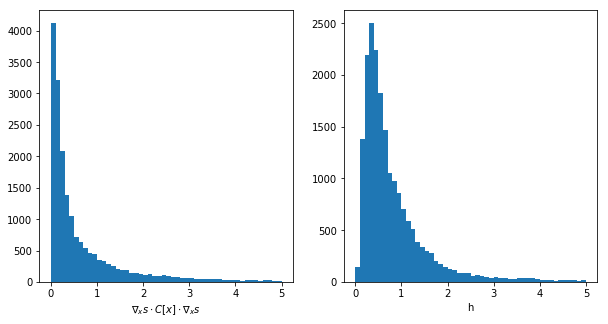

In [236]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(grad_cov_grad, 50, range=(0,5))
plt.xlabel(r'$\nabla_x s \cdot C[x] \cdot \nabla_x s$')

plt.subplot(1,2,2)
plt.hist(bandwidths, 50, range=(0.,5.))
plt.xlabel(r'h')

plt.show()

# Calibration

In [237]:
pdf_nom_grad = GaussianKDE(alpha=0.5)
pdf_nom_grad.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta,::], bandwidth=bandwidths_nom)

grad_bandwidths_nom = 1. / pdf_nom_grad._inv_loc_bw

pdf_den_grad = GaussianKDE(alpha=0.5)
pdf_den_grad.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta1,::], bandwidth=bandwidths_den)

grad_bandwidths_den = 1. / pdf_den_grad._inv_loc_bw

cov:
[[0.00694508]]
Input bw:
(19994,)
0.13889838678551894
[0.1 0.1 0.1 ... 0.1 0.1 0.1]
Standardized input bw:
(19994,)
1.6667047184212054
[1.19994534 1.19994534 1.19994534 ... 1.19994534 1.19994534 1.19994534]
Inverse local bandwidth:
(19994,)
0.7342151506901785
[0.83337129 0.83337129 0.83337129 ... 0.83337129 0.83337129 0.83337129]
cov:
[[0.02628096]]
Input bw:
(19994,)
0.18163897726541584
[0.1        0.1        0.1        ... 0.1        0.1        0.12013491]
Standardized input bw:
(19994,)
1.1204396330404327
[0.61684978 0.61684978 0.61684978 ... 0.61684978 0.61684978 0.74105193]
Inverse local bandwidth:
(19994,)
1.264997792205793
[1.62114024 1.62114024 1.62114024 ... 1.62114024 1.62114024 1.3494331 ]


In [238]:
pdf_nom_adaptive = GaussianKDE(alpha=0.5)
pdf_nom_adaptive.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta,::])

adaptive_bandwidths_nom = 1. / pdf_nom_adaptive._inv_loc_bw

pdf_den_adaptive = GaussianKDE(alpha=0.5)
pdf_den_adaptive.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta1,::])

adaptive_bandwidths_den = 1. / pdf_den_adaptive._inv_loc_bw

Local bandwidth:
(19994,)
[1.62839322 1.30376434 1.79304634 ... 1.82681433 1.80112707 1.39812638]
Local bandwidth:
(19994,)
[1.37564976 1.10486597 1.39954096 ... 1.36362549 1.39871484 1.27878012]


In [239]:
pdf_nom_fix = GaussianKDE(alpha=None)
pdf_nom_fix.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta,::])

fix_bandwidths_nom = np.ones_like(s_hat_calibration)

pdf_den_fix = GaussianKDE(alpha=None)
pdf_den_fix.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta1,::])

fix_bandwidths_den = np.ones_like(s_hat_calibration)

In [292]:
s = np.hstack((s_hat_calibration,s_hat_calibration))
y = np.hstack((np.zeros_like(s_hat_calibration), np.ones_like(s_hat_calibration)))
w = np.hstack((weights_calibration[theta,::], weights_calibration[theta1,::]))

calibrator_hist = HistogramCalibrator(bins=50, independent_binning=False, variable_width=True)
calibrator_hist.fit(s, y, sample_weight=w)

calibrator_iso = IsotonicCalibrator()
calibrator_iso.fit(s, y, sample_weight=w)

IsotonicCalibrator(increasing=True, interpolation=False, y_max=None,
          y_min=None)

In [304]:
si = np.linspace(0., 1., 200).reshape((-1,1))

p_nom_grad_eval = pdf_nom_grad.predict(si)
p_den_grad_eval = pdf_den_grad.predict(si)
r_grad_eval = p_nom_grad_eval / p_den_grad_eval

p_nom_adaptive_eval = pdf_nom_adaptive.predict(si)
p_den_adaptive_eval = pdf_den_adaptive.predict(si)
r_adaptive_eval = p_nom_adaptive_eval / p_den_adaptive_eval

p_nom_fix_eval = pdf_nom_fix.predict(si)
p_den_fix_eval = pdf_den_fix.predict(si)
r_fix_eval = p_nom_fix_eval / p_den_fix_eval

s_histo_eval = calibrator_hist.predict(si.reshape((-1,)))
r_histo_eval = (1. - s_histo_eval) / s_histo_eval

s_iso_eval = calibrator_iso.predict(si.reshape((-1,)))
r_iso_eval = (1. - s_iso_eval) / s_iso_eval

# Calibration curves

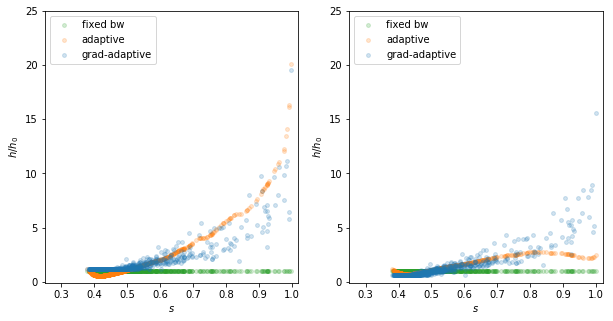

In [246]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(s_hat_calibration[::20], fix_bandwidths_nom[::20], c='C2', s=15., alpha=0.2, label='fixed bw')
plt.scatter(s_hat_calibration[::20], adaptive_bandwidths_nom[::20], c='C1', s=15., alpha=0.2, label='adaptive')
plt.scatter(s_hat_calibration[::20], grad_bandwidths_nom[::20], c='C0', s=15., alpha=0.2, label='grad-adaptive')
plt.legend()
plt.xlabel(r'$s$')
plt.ylabel(r'$h/h_0$')
plt.xlim(0.25,1.02)
plt.ylim(-0.1,25.)

plt.subplot(1,2,2)
plt.scatter(s_hat_calibration[::20], fix_bandwidths_den[::20], c='C2', s=15., alpha=0.2, label='fixed bw')
plt.scatter(s_hat_calibration[::20], adaptive_bandwidths_den[::20], c='C1', s=15., alpha=0.2, label='adaptive')
plt.scatter(s_hat_calibration[::20], grad_bandwidths_den[::20], c='C0', s=15., alpha=0.2, label='grad-adaptive')
plt.legend(loc='upper left')
plt.xlabel(r'$s$')
plt.ylabel(r'$h/h_0$')
plt.xlim(0.25,1.02)
plt.ylim(-0.1,25.)

plt.show()

In [244]:
print(np.mean(adaptive_bandwidths_den), np.mean(grad_bandwidths_den))

1.0947772864036363 1.1204396330404327


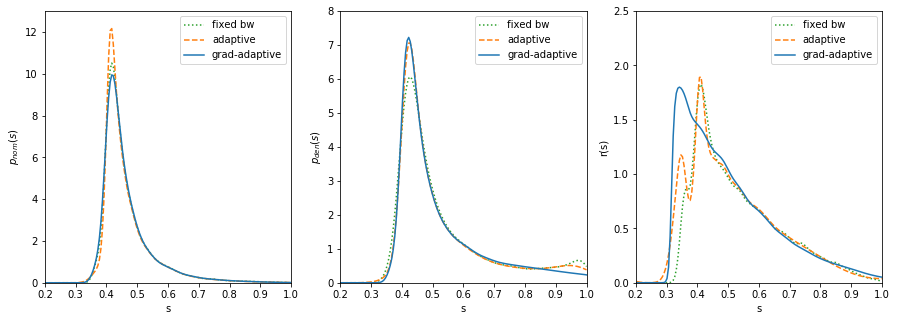

In [247]:
plt.figure(figsize=(15.,5.))

plt.subplot(1,3,1)
plt.plot(si,p_nom_fix_eval, c='C2', ls=':', label='fixed bw')
plt.plot(si,p_nom_adaptive_eval, c='C1', ls='--', label='adaptive')
plt.plot(si,p_nom_grad_eval, c='C0', ls='-', label='grad-adaptive')
plt.xlabel('s')
plt.ylabel(r'$p_{nom}(s)$')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,13.)

plt.subplot(1,3,2)
plt.plot(si,p_den_fix_eval, c='C2', ls=':', label='fixed bw')
plt.plot(si,p_den_adaptive_eval, c='C1', ls='--', label='adaptive')
plt.plot(si,p_den_grad_eval, c='C0', ls='-', label='grad-adaptive')
plt.xlabel('s')
plt.ylabel(r'$p_{den}(s)$')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,8.)

plt.subplot(1,3,3)
plt.plot(si,r_fix_eval, c='C2', ls=':', label='fixed bw')
plt.plot(si,r_adaptive_eval, c='C1', ls='--', label='adaptive')
plt.plot(si,r_grad_eval, c='C0', ls='-', label='grad-adaptive')
plt.xlabel('raw s')
plt.ylabel('r(s)')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,2.5)

plt.show()

# Effects on r estimation

In [254]:
r_hat_test = np.exp(regr.predict(X_test_transformed)[:,0])
s_hat_test = 1. / (1. + r_hat_test)

In [256]:
r_hat_calibrated_grad_test = (pdf_nom_grad.predict(s_hat_test.reshape((-1,1)))
                              / pdf_den_grad.predict(s_hat_test.reshape((-1,1))))
r_hat_calibrated_adaptive_test = (pdf_nom_adaptive.predict(s_hat_test.reshape((-1,1)))
                              / pdf_den_adaptive.predict(s_hat_test.reshape((-1,1))))
r_hat_calibrated_fix_test = (pdf_nom_fix.predict(s_hat_test.reshape((-1,1)))
                              / pdf_den_fix.predict(s_hat_test.reshape((-1,1))))

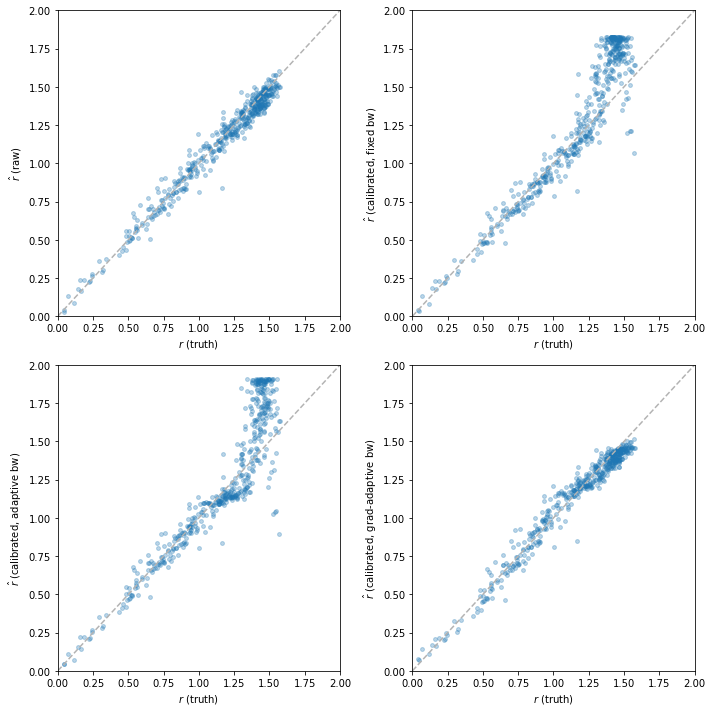

In [263]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot([0.,2.],[0.,2.],ls='--', c='0.7')
plt.scatter(r_test[::100], r_hat_test[::100], s=15., alpha=0.3)
plt.xlim(0.,2.)
plt.ylim(0.,2.)
plt.xlabel('$r$ (truth)')
plt.ylabel(r'$\hat{r}$ (raw)')

plt.subplot(2,2,2)
plt.plot([0.,2.],[0.,2.],ls='--', c='0.7')
plt.scatter(r_test[::100], r_hat_calibrated_fix_test[::100], s=15., alpha=0.3)
plt.xlabel('$r$ (truth)')
plt.ylabel(r'$\hat{r}$ (calibrated, fixed bw)')
plt.xlim(0.,2.)
plt.ylim(0.,2.)

plt.subplot(2,2,3)
plt.plot([0.,2.],[0.,2.],ls='--', c='0.7')
plt.scatter(r_test[::100], r_hat_calibrated_adaptive_test[::100], s=15., alpha=0.3)
plt.xlabel('$r$ (truth)')
plt.ylabel(r'$\hat{r}$ (calibrated, adaptive bw)')
plt.xlim(0.,2.)
plt.ylim(0.,2.)

plt.subplot(2,2,4)
plt.plot([0.,2.],[0.,2.],ls='--', c='0.7')
plt.scatter(r_test[::100], r_hat_calibrated_grad_test[::100], s=15., alpha=0.3)
plt.xlabel('$r$ (truth)')
plt.ylabel(r'$\hat{r}$ (calibrated, grad-adaptive bw)')
plt.xlim(0.,2.)
plt.ylim(0.,2.)

plt.tight_layout()
plt.show()

# Comparison to other methods

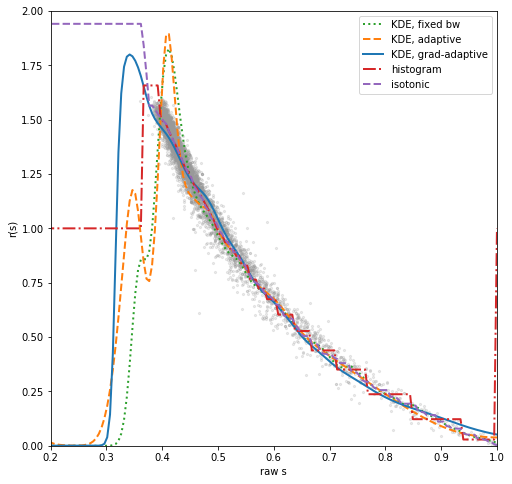

In [305]:
plt.figure(figsize=(8,8))

plt.scatter(s_hat_test[::10], r_test[::10], c='0.6', s=5., alpha=0.2)

plt.plot(si,r_fix_eval, c='C2', ls=':', lw=2., label='KDE, fixed bw')
plt.plot(si,r_adaptive_eval, c='C1', ls='--', lw=2., label='KDE, adaptive')
plt.plot(si,r_grad_eval, c='C0', ls='-', lw=2., label='KDE, grad-adaptive')

plt.plot(si,r_histo_eval, c='C3', ls='-.', lw=2., label='histogram')
plt.plot(si,r_iso_eval, c='C4', ls='--', lw=2., label='isotonic')

plt.xlabel('raw s')
plt.ylabel('r(s)')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,2.)

plt.show()

In [ ]:
print('KDE, fixed bw:', mean_squared_error())